# Customer Segmentation using RFM Analysis

This notebook performs customer segmentation based on Recency, Frequency,
and Monetary (RFM) metrics using retail transaction data.


In [2]:
import pandas as pd

# Load the dataset (CSV)
df = pd.read_csv("../data/OnlineRetail.csv", encoding="latin1")

# Preview data
df.head()

# Structure
df.info()

# Columns
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [3]:
# Clean data for Customer Segmentation (RFM-ready)

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Remove rows with missing customer ID
df = df.dropna(subset=["CustomerID"])

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Remove negative or zero values
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [4]:
# Create a snapshot date
# Snapshot date (one day after last transaction)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

snapshot_date


Timestamp('2011-12-10 12:50:00')

In [5]:
# Total value per transaction row
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]


In [ ]:
# Calculate RFM metric
rfm = (
    df.groupby("CustomerID")
      .agg({
          "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
          "InvoiceNo": "nunique",                                    # Frequency
          "TotalAmount": "sum"                                      # Monetary
      })
      .reset_index()
)

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [7]:
# Create R,F,M scores
# RFM scoring using quartiles
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])


In [10]:
# Create combined RFM scores
rfm["RFM_Score"] = (
    rfm["R_score"].astype(str) +
    rfm["F_score"].astype(str) +
    rfm["M_score"].astype(str)
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112


In [11]:
# Convert R,F,M scores into integers to avoid comparison issues
rfm["R_score"] = rfm["R_score"].astype(int)
rfm["F_score"] = rfm["F_score"].astype(int)
rfm["M_score"] = rfm["M_score"].astype(int)


In [13]:
# Create segmentation logic
def segment_customer(row):
    if row["R_score"] >= 3 and row["F_score"] >= 3 and row["M_score"] >= 3:
        return "Champions"
    elif row["R_score"] >= 3 and row["F_score"] >= 2:
        return "Loyal Customers"
    elif row["R_score"] >= 2 and row["F_score"] >= 2:
        return "Potential Loyalists"
    elif row["R_score"] <= 2 and row["F_score"] >= 2:
        return "At Risk"
    else:
        return "Lost Customers"

rfm["Customer_Segment"] = rfm.apply(segment_customer, axis=1)

rfm["Customer_Segment"].value_counts()


Customer_Segment
Champions              1319
Lost Customers         1085
Potential Loyalists     759
Loyal Customers         610
At Risk                 565
Name: count, dtype: int64

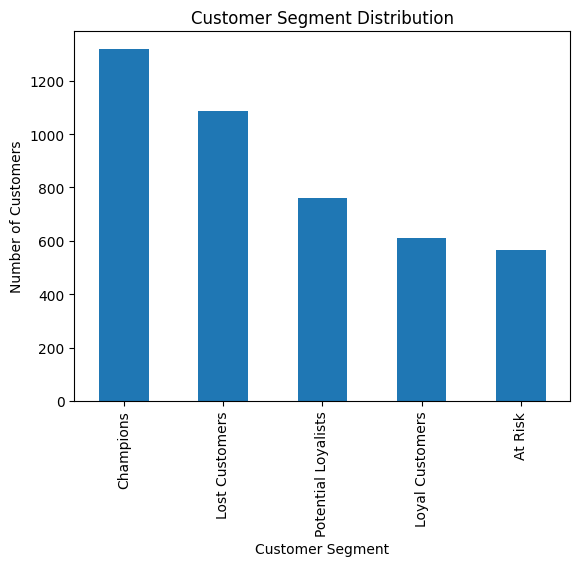

In [15]:
# Segment distribution bar chart
import matplotlib.pyplot as plt

segment_counts = rfm["Customer_Segment"].value_counts()

segment_counts.plot(kind="bar")
plt.title("Customer Segment Distribution")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()


In [16]:
# Segemnt-level summary table
segment_summary = (
    rfm.groupby("Customer_Segment")
       .agg({
           "Recency": "mean",
           "Frequency": "mean",
           "Monetary": "mean"
       })
       .round(2)
       .reset_index()
)

segment_summary


,Customer_Segment,Recency,Frequency,Monetary
0,At Risk,232.38,2.20,808.03
1,Champions,17.09,9.38,4932.94
2,Lost Customers,156.31,1.00,450.17
3,Loyal Customers,23.37,2.18,827.33
4,Potential Loyalists,83.96,3.30,1258.53
